In [1]:
from rdkit import Chem
import pickle
import numpy as np
import pandas as pd
from IPython.display import display
from copy import deepcopy

# Load processed data

In [2]:
dataset = pd.read_csv("/home/abhor/Desktop/datasets/my_uspto/processed_data.csv", index_col=0)

In [3]:
dataset

,reactants,reagents,products
0,CON(C)C(=O)c1ccc(O)nc1,C1CCOC1.[Cl-],CC(C)CC(=O)c1ccc(O)nc1
1,O=C(O)c1ccc(Cl)c([N+](=O)[O-])c1,O,CNc1ccc(C(=O)O)cc1[N+](=O)[O-]
2,CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(N)cc3)cc21,NaN,CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(NC=O)cc3)cc21
3,COCC(C)Oc1cc(Oc2cnc(C(=O)N3CCC3)cn2)cc(C(=O)O)c1,CC(C)=C(Cl)N(C)C.ClCCl.c1ccncc1,COCC(C)Oc1cc(Oc2cnc(C(=O)N3CCC3)cn2)cc(C(=O)Nc...
4,Clc1cc2c(Cl)nc(-c3ccncc3)nc2s1,NaN,Clc1cc2c(NCc3ccc(Cl)c(Cl)c3)nc(-c3ccncc3)nc2s1
...,...,...,...
448504,CCP(CC)CC,NaN,CCCCOS(=O)(=O)[O-]
448505,CCCCOS(=O)(=O)OCCCC,NaN,CCCC[P+](CC)(CC)CC
448506,Cc1cccc(C)c1N=C1NCCN1OCc1ccccn1,CC#N.Cl,Cc1cccc(C)c1N=C1NCCN1O
448507,Clc1ccnc(Cl)c1,ClCCl,N[n+]1ccc(Cl)cc1Cl


# Reaction signature

In [4]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import DataStructs
from rdkit.Chem import rdFMCS
from rdkit.Chem import AllChem

In [5]:
mol1 = Chem.MolFromSmiles(dataset["reactants"][0])
mol2 = Chem.MolFromSmiles(dataset["products"][0])

In [6]:
def get_connecting_atoms(mol, subgraph):
    '''
    Finds pair of atoms that connect 'mol' to 'subgraph'
    mol: Complete molecule
    subgraph: Part of mol (reaction signatire)
    
    Returns:
        [(A1, A2), (A1', A2'), ...]
        Where each tuple is a connected pair of atom such that A1 \in subgraph, A2 \in (mol-subgraph)
    '''
    # get subgraph matches
    matches = np.array(mol.GetSubstructMatches(subgraph))
    connections = []
    for match in matches:
        # atoms in connected subgraph
        atoms = [mol.GetAtomWithIdx(int(match[i])) for i in range(len(match))]
        for atom in atoms:
            # for each atom in connected subgraph, get neighbors
            neighbors = atom.GetNeighbors()
            neighbor_idx = set([n.GetIdx() for n in neighbors])
            # if there is a neighbor in (mol - subgraph), add connection to 
            if (neighbor_idx - set(match)):
                if len(neighbor_idx - set(match)) == 1:
                    connections.append((atom.GetIdx(), (neighbor_idx - set(match)).pop()))

    # remove repetitions
    connections = list(set(connections))
    return connections

def connect_substructures_if_applicable(mol, connections):
    '''
    If multiple connections have an atom in common, combine the substructures with the connection atom.
    Even if not, add the connecting atom to the substructure to maintain uniformity.
    mol: Molecule
    connections: (same as return of get_connecting_atoms)
    
    Returns:
        connections with substructures combined (same format as input connections)
    '''
    # combine if two connections have common atom in substructure
    d = {conn[1]: [] for conn in connections}
    for conn in connections:
        d[conn[1]].append(conn)
    connections = []
    for key in d:
        # combine
        atom = mol.GetAtomWithIdx(key)
        neighbors = atom.GetNeighbors()
        # get neighbors not in previous connections
        neighbor_idx = set([n.GetIdx() for n in neighbors]) - set([n[0] for n in d[key]])
        if len(neighbor_idx) == 1:
            for idx in neighbor_idx:
                connections.append((key, idx))
        else:
            # let it be
            connections.extend(d[key])
    return connections

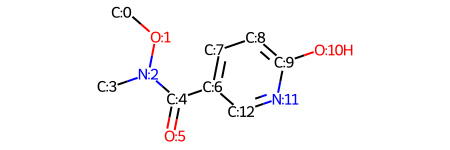

In [7]:
# draw molecule with index
def mol_with_atom_index( mol ):
    mol = deepcopy(mol)
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol
mol_with_atom_index(mol1)

Common substructure


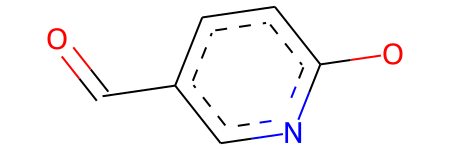

mol1 - common


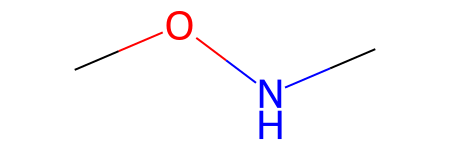

mol2 - common


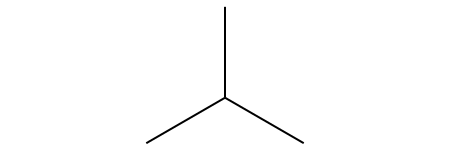

(<rdkit.Chem.rdchem.Mol at 0x7f15815f4d00>,
 <rdkit.Chem.rdchem.Mol at 0x7f15815fb800>)

In [8]:
def get_substructures(mol1, mol2, disp=False):
    '''
    Takes 2 molecules. 
    Returns (common_substructure, reac_sig1, reac_sig2)
    '''
    # find common substruction (to later substract)
    res=rdFMCS.FindMCS([mol1, mol2])
    common_substructure = Chem.MolFromSmarts(res.smartsString)
    if disp: 
        print("Common substructure")
        display(common_substructure)

    # reaction signature in mol 1
    mol1_diff = AllChem.DeleteSubstructs(mol1, common_substructure)
    if disp: 
        print("mol1 - common")
        display(mol1_diff)

    # reaction signature in mol 2
    mol2_diff = AllChem.DeleteSubstructs(mol2, common_substructure)
    if disp: 
        print("mol2 - common")
        display(mol2_diff)
    
    return common_substructure, mol1_diff, mol2_diff
    
get_substructures(mol1, mol2, disp=True)

In [9]:
def get_reaction_signatures(i, disp=False):
    mol1 = Chem.MolFromSmiles(dataset["reactants"][i])
    mol2 = Chem.MolFromSmiles(dataset["products"][i])

    # display raw mols
    if disp:
        print("Mol1")
        display(mol1)

        print("Mol2")
        display(mol2)

    # get reaction signatures
    common_substructure, mol1_diff, mol2_diff = get_substructures(mol1, mol2, disp=disp)
    print(Chem.MolToSmiles(mol1_diff))
    print(Chem.MolToSmiles(mol2_diff))

    if disp:
        print("-"*100)

    # display with indices
    if disp: 
        print("With indices - mol1, mol2 and common")
        display(mol_with_atom_index(mol1))
        display(mol_with_atom_index(mol2))
        display(mol_with_atom_index(common_substructure))

    if disp:
        print("-"*100)

    # mapping of molecule idx to common_substructure idx
    mol1_to_com_map = np.array(mol1.GetSubstructMatch(common_substructure))
    mol2_to_com_map = np.array(mol2.GetSubstructMatch(common_substructure))

    def comm_idx1(idx):
        '''
        return the atom idx in comm_sub corresponding to 'idx' in mol1
        '''
        arr = abs(np.array(mol1_to_com_map) - idx)
        if 0 not in arr:
            return -1
        return arr.argmin()

    def comm_idx2(idx):
        '''
        return the atom idx in comm_sub corresponding to 'idx' in mol2
        '''
        arr = abs(np.array(mol2_to_com_map) - idx)
        if 0 not in arr:
            return -1
        return arr.argmin()


    com_to_mol1_map = list(map(comm_idx1, mol1_to_com_map))
    com_to_mol2_map = list(map(comm_idx2, mol2_to_com_map))

    if disp:
        print("mol1_to_com_map", mol1_to_com_map)
        print("mol2_to_com_map", mol2_to_com_map)
        print("com_to_mol1_map", com_to_mol1_map)
        print("com_to_mol2_map", com_to_mol2_map)

    # get connection points
    con1 = get_connecting_atoms(mol1, mol1_diff)
    con2 = get_connecting_atoms(mol2, mol2_diff)

    con1 = list(filter(lambda x: (comm_idx1(x[1]) in com_to_mol1_map) and \
                                   (comm_idx1(x[0]) not in com_to_mol1_map), con1))
    con2 = list(filter(lambda x: (comm_idx2(x[1]) in com_to_mol2_map) and \
                                   (comm_idx2(x[0]) not in com_to_mol2_map), con2))
    
    con1, con2 = connect_substructures_if_applicable(mol1, con1), connect_substructures_if_applicable(mol2, con2)
    
    if disp:
        print("Con1", con1)
        print("Con2", con2)
        if con1 and con2:
            print("Common idx for connection:", comm_idx1(con1[0][1]), comm_idx2(con2[0][1]))

    # verification
    assert len(con1) <= 1
    assert len(con2) <= 1

Mol1


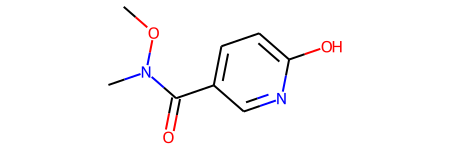

Mol2


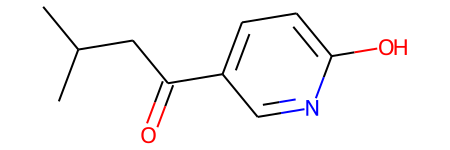

Common substructure


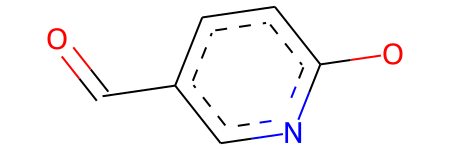

mol1 - common


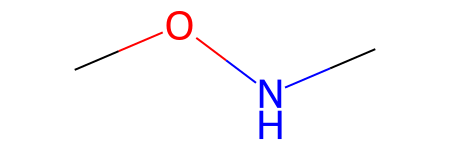

mol2 - common


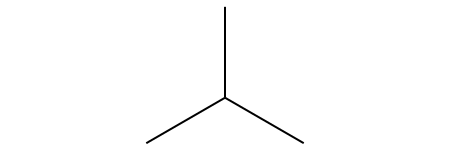

CNOC
CC(C)C
----------------------------------------------------------------------------------------------------
With indices - mol1, mol2 and common


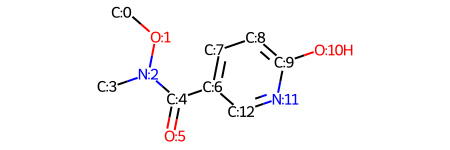

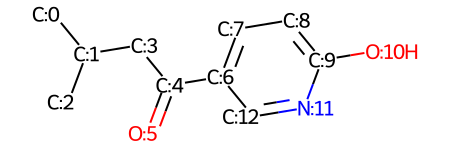

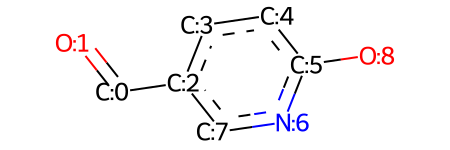

----------------------------------------------------------------------------------------------------
mol1_to_com_map [ 4  5  6  7  8  9 11 12 10]
mol2_to_com_map [ 4  5  6  7  8  9 11 12 10]
com_to_mol1_map [0, 1, 2, 3, 4, 5, 6, 7, 8]
com_to_mol2_map [0, 1, 2, 3, 4, 5, 6, 7, 8]
Con1 [(2, 4)]
Con2 [(3, 4)]
Common idx for connection: 0 0


In [13]:
get_reaction_signatures(0, True)

In [14]:
special_cases = [42, 64, 74, 113, 170, 193, 225, 487]
special_cases = [487]

CNOC
CC(C)C
0 0.004478931427001953
Cl
CN
1 0.0010197162628173828

C=O
2 0.001207590103149414
O
Cc1cnc(N)cn1
3 0.0022208690643310547
Cl
NCc1ccc(Cl)c(Cl)c1
4 0.0028769969940185547
C#N

5 0.0008869171142578125
O=S(=O)(O)C(F)(F)F
CC(N)c1ccc(F)c(Cl)c1
6 0.0015568733215332031
C[SH](=O)=O
CCOC=O
7 0.001434326171875

CC(C=O)C(=O)NCc1ccc(F)cc1
8 0.0010752677917480469
O
CC(=O)N1CCN(c2ccc(N)nc2)CC1
9 0.0009799003601074219

C
10 0.0019290447235107422
c1ccccc1
C[SH](=O)=O
11 0.0008039474487304688

O=Cc1cccnc1
12 0.0005891323089599609

Br
13 0.0007681846618652344
O
O
14 0.0008637905120849609
COC(C)=O
COC(C)=O
15 0.0011441707611083984
Cl
CC(C)CC1CNCCN1
16 0.0008084774017333984

O
17 0.0011737346649169922

O=CNc1ccc(Br)cc1
18 0.0007784366607666016

O=COc1ccccc1
19 0.0008745193481445312
I
NN
20 0.0005211830139160156

O=[N+][O-]
21 0.001043558120727539
Br
N#CS
22 0.0006995201110839844

O=[N+][O-]
23 0.0008614063262939453

N=O
24 0.0005447864532470703
Cl
CNC
25 0.014023542404174805
CC(C)(C)OC=O

26 0.000

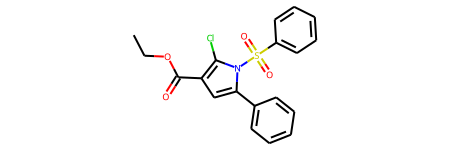

Mol2


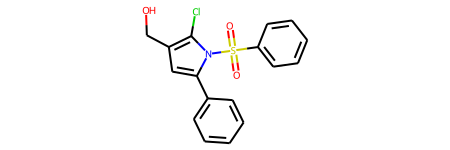

Common substructure


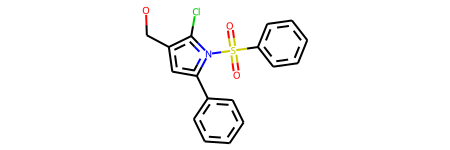

mol1 - common


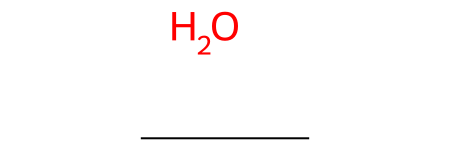

mol2 - common


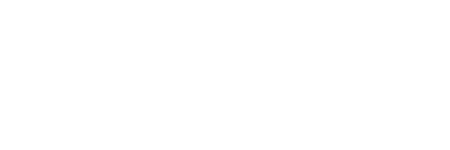

CC.O

----------------------------------------------------------------------------------------------------
With indices - mol1, mol2 and common


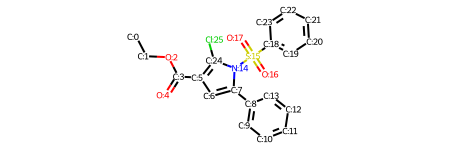

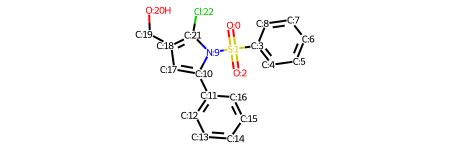

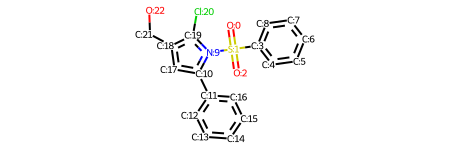

----------------------------------------------------------------------------------------------------
mol1_to_com_map [16 15 17 18 19 20 21 22 23 14  7  8  9 10 11 12 13  6  5 24 25  3  2]
mol2_to_com_map [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 21 22 19 20]
com_to_mol1_map [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
com_to_mol2_map [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
Con1 [(2, 3), (4, 3)]
Con2 []


O=[N+][O-]
43 0.0010807514190673828
Br
C1COCCN1
44 0.0006711483001708984

O=Cc1ccc(Cl)s1
45 0.0011568069458007812
Cl
NCCCCN
46 0.0009381771087646484

O=Cc1c[nH]c2ccccc12
47 0.0010814666748046875

O=CCN1CCCCC1
48 0.0015034675598144531

O
49 0.0010991096496582031
Cl
C#N
50 0.0013577938079833984

CC(N)=O
51 0.0007107257843017578

CCOc1ccc(C=O)c(O)c1
52 0.0009932518005371094

C[SH](=O)=O
53 0.0009295940399169922
CC1(C)OBOC1(C)C
COc1ccc(-c2ccncc2)nn1
54 0.001401662826538086
O

55 0.0005869865417

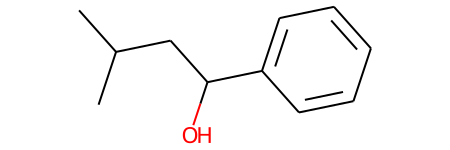

Mol2


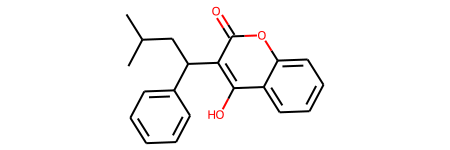

Common substructure


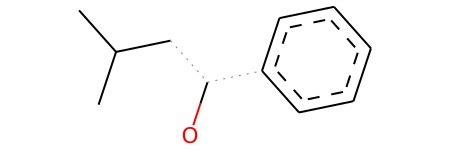

mol1 - common


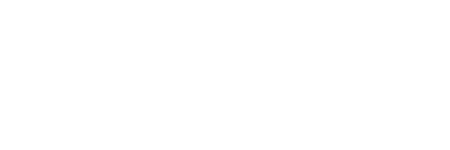

mol2 - common


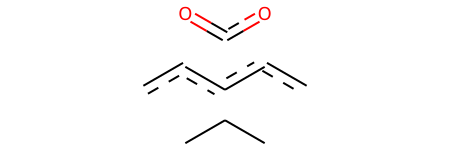


CCC.O=co.ccccc
----------------------------------------------------------------------------------------------------
With indices - mol1, mol2 and common


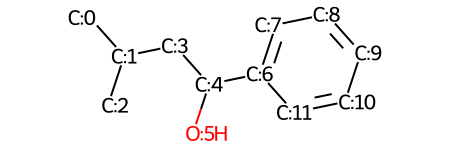

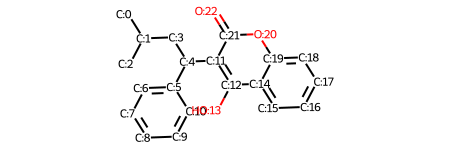

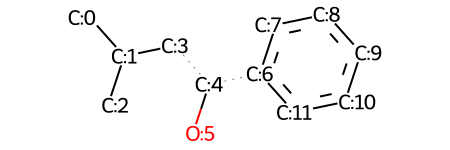

----------------------------------------------------------------------------------------------------
mol1_to_com_map [ 0  1  2  3  4  5  6  7  8  9 10 11]
mol2_to_com_map [ 3  4  5 11 12 13 14 15 16 17 18 19]
com_to_mol1_map [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
com_to_mol2_map [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Con1 []
Con2 [(3, 4), (20, 19), (21, 11), (5, 4)]

C

65 0.0008687973022460938
Cl
c1cc2[nH]ccc2cn1
66 0.0006246566772460938
C
O
67 0.0012154579162597656
Cl
C1CNCCN1
68 0.0011670589447021484
Cc1ccccc1

69 0.0009856224060058594
Br
C1CCNCC1
70 0.0008206367492675781
O
C.O
71 0.0005376338958740234
Cc1ccc([SH](=O)=O)cc1
c1ccc(-c2ccccc2)cc1
72 0.0008444786071777344
N
N.S
73 0.0010030269622802734
C.C

74
Mol1


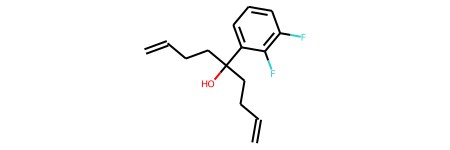

Mol2


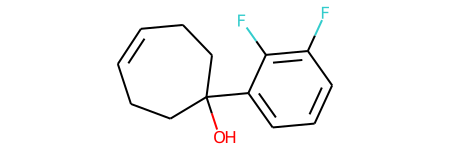

Common substructure


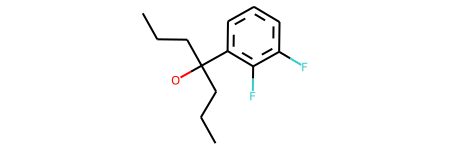

mol1 - common


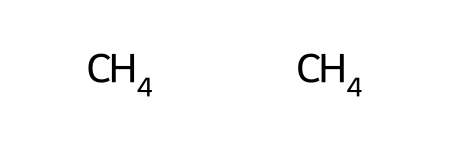

mol2 - common


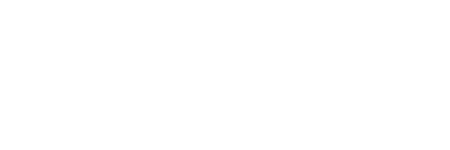

C.C

----------------------------------------------------------------------------------------------------
With indices - mol1, mol2 and common


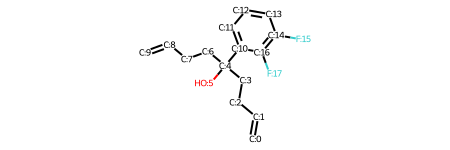

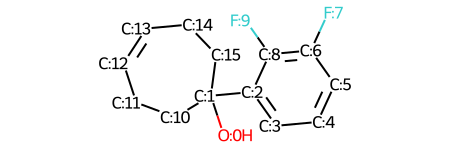

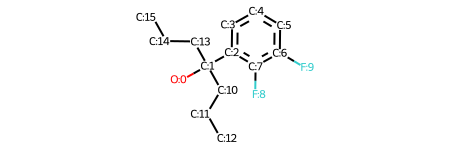

----------------------------------------------------------------------------------------------------
mol1_to_com_map [ 5  4 10 11 12 13 14 16 17 15  3  2  1  6  7  8]
mol2_to_com_map [ 0  1  2  3  4  5  6  8  9  7 10 11 12 15 14 13]
com_to_mol1_map [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
com_to_mol2_map [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Con1 [(8, 7), (1, 2)]
Con2 []

O
O
75 0.0010335445404052734
Cl
CN1CCC(O)CC1
76 0.0006268024444580078

CNC(=O)CCl
77 0.0008080005645751953
N.O
N
78 0.0009891986846923828

CCOC(=O)CCCc1ccccc1
79 0.0011866092681884766

NC=O
80 0.0009591579437255859

COC=O
81 0.0009665489196777344
Cc1ccccc1

82 0.0013484954833984375
OBO
N#Cc1cccnc1
83 0.0006711483001708984
Cl
CCOC(=O)Cc1csc(N)n1
84 0.0006937980651855469
Cl
Brc1cccc2c1CCCN2
85 0.0008828639984130859
N
N.O
86 0.001268148422241211
Br
N
87 0.000986337661743164
CC(C)(C)OC=O

88 0.0007328987121582031
OBO
Cc1ccnn1
89 0.00066375732421875
O
Cc1ccncn1
90 0.0006682872772216797
Cl
c1c

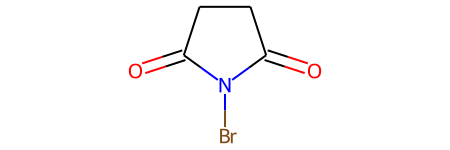

Mol2


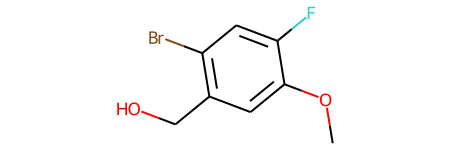

Common substructure


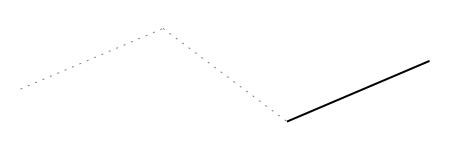

mol1 - common


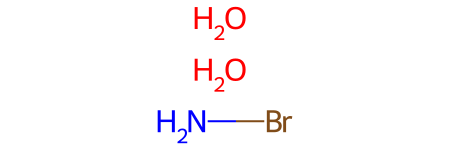

mol2 - common


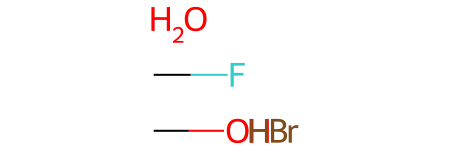

NBr.O.O
Br.CO.O.cF
----------------------------------------------------------------------------------------------------
With indices - mol1, mol2 and common


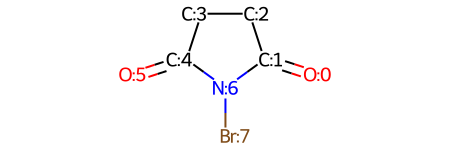

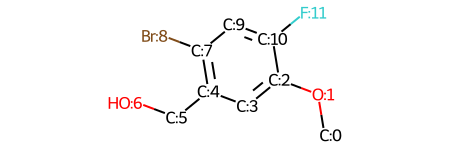

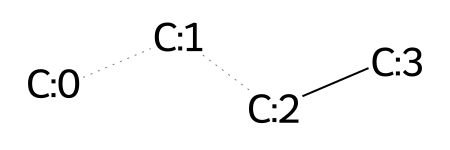

----------------------------------------------------------------------------------------------------
mol1_to_com_map [1 2 3 4]
mol2_to_com_map [2 3 4 5]
com_to_mol1_map [0, 1, 2, 3]
com_to_mol2_map [0, 1, 2, 3]
Con1 [(0, 1), (5, 4)]
Con2 [(1, 2), (5, 4)]
Common idx for connection: 0 0

F
O=[N+]([O-])c1ccc(O)cc1OCc1ccccc1
114 0.13936185836791992

CNC=S
115 0.0005228519439697266

CCCCl
116 0.0006651878356933594

CC=O
117 0.0013823509216308594

CCCCCCCCCCCC=O
118 0.001374959945678711
CC1(C)OBOC1(C)C
CC(C)(O)COc1ccccn1
119 0.0019834041595458984

C[SH](=O)=O
120 0.001154184341430664

O=Cc1cccs1
121 0.0010190010070800781
Cl
CC(C)COC1CCNCC1
122 0.0008425712585449219
Br
C#N
123 0.0012960433959960938
OBO
Cc1ccc(C)cc1
124 0.0008008480072021484
O
C=COCC
125 0.0005013942718505859

C
126 0.0019228458404541016
C

127 0.0011942386627197266
O
Nc1ccc(Cl)nn1
128 0.0015003681182861328
c1ccc(Cc2ccccc2)cc1

129 0.0011053085327148438

CC=O
130 0.0007727146148681641

C
131 0.002450227737426758

CC=O
132 0.00

KeyboardInterrupt: 

In [16]:
import time
for i in range(0, 1000):
    if i not in special_cases:
        try:
            t = time.time()
            get_reaction_signatures(i)
            print(i, time.time() - t)
        except Exception as e:
            try:
                print(i)
                get_reaction_signatures(i, disp=True)
                print("\n\n")
            except Exception as e:
                print(e)